In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
dataset_path = '/dataset'
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 92 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=val_data, epochs=10)
model.save("cnn_model.h5")
# model.save("/content/drive/MyDrive/cnn_model.keras", save_format="keras")

Epoch 1/10
3/3 [==============================] - 21s 6s/step - loss: 1.9414 - accuracy: 0.4891 - val_loss: 2.1153 - val_accuracy: 0.5455
Epoch 2/10
3/3 [==============================] - 12s 4s/step - loss: 1.2408 - accuracy: 0.4674 - val_loss: 0.7162 - val_accuracy: 0.4545
Epoch 3/10
3/3 [==============================] - 12s 4s/step - loss: 0.7282 - accuracy: 0.4457 - val_loss: 0.6778 - val_accuracy: 0.5455
Epoch 4/10
3/3 [==============================] - 12s 4s/step - loss: 0.6876 - accuracy: 0.5543 - val_loss: 0.6835 - val_accuracy: 0.5455
Epoch 5/10
3/3 [==============================] - 12s 4s/step - loss: 0.6890 - accuracy: 0.5543 - val_loss: 0.6764 - val_accuracy: 0.5455
Epoch 6/10
3/3 [==============================] - 12s 4s/step - loss: 0.6959 - accuracy: 0.4348 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 13s 4s/step - loss: 0.6718 - accuracy: 0.6957 - val_loss: 0.6665 - val_accuracy: 0.5455
Epoch 8/10
3/3 [==================

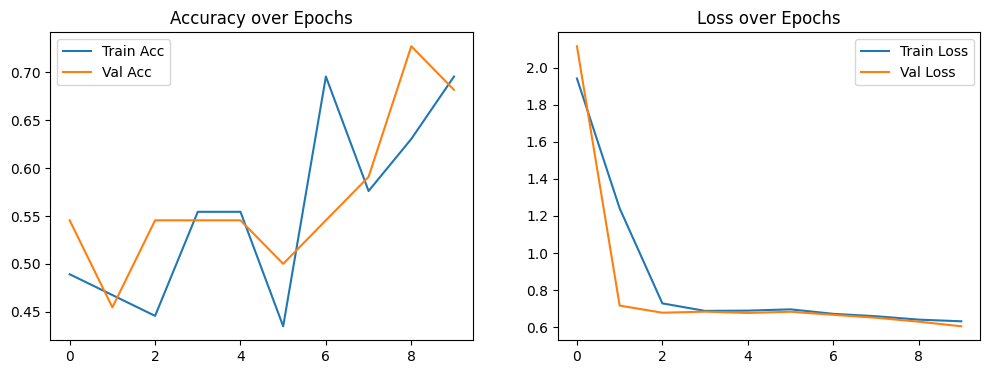

In [5]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

In [6]:
# Call the model to initialize input
_ = model.predict(next(iter(train_data))[0])

# Create feature extractor (from last Conv layer)
# Access input layer through model.layers[0]
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

def extract_features(data_generator, extractor):
    features, labels = [], []
    for i in range(len(data_generator)):
        x_batch, y_batch = next(data_generator)
        features.append(extractor.predict(x_batch))
        labels.extend(y_batch)
    return np.vstack(features), np.array(labels)

train_data.reset()
val_data.reset()

X_train, y_train = extract_features(train_data, feature_extractor)
X_val, y_val = extract_features(val_data, feature_extractor)

1/1 [==============================] - 1s 658ms/step


✅ RandomForest Accuracy: 0.7272727272727273

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75        12
         1.0       0.70      0.70      0.70        10

    accuracy                           0.73        22
   macro avg       0.72      0.72      0.72        22
weighted avg       0.73      0.73      0.73        22



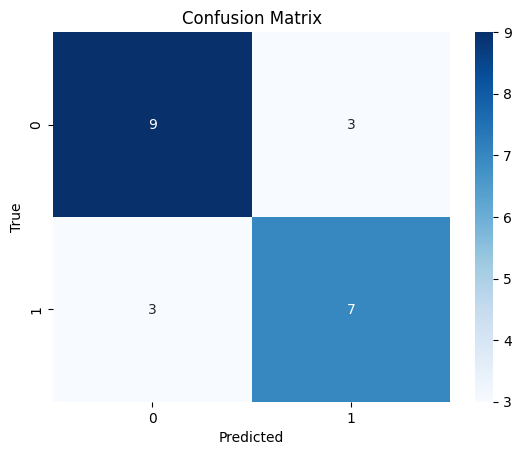

['dental_rf_model.pkl']

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_val)
acc = accuracy_score(y_val, y_pred_rf)
print("✅ RandomForest Accuracy:", acc)

print("\nClassification Report:\n", classification_report(y_val, y_pred_rf))

cm = confusion_matrix(y_val, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save .pkl model
joblib.dump(rf_model, 'dental_rf_model.pkl')
# print("✅ Model saved as .pkl to Google Drive")